<a href="https://colab.research.google.com/github/tqiaowen/LSTrAP-Cloud/blob/master/mod_neighbourhood_and_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#2. Generating Neighbourhood and Network Files
This script is based on the original download script found [here](https://github.com/wirriamm/CoNeGC/blob/master/2_Generating_neighbourhood_and_network_files_30Jan.ipynb), obtained on 03 February 2020.

In [1]:
#@title Mount Google Drive

#Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')
!rm -rf /content/sample_data
!wget https://raw.githubusercontent.com/wirriamm/CoNeGC/master/Dependencies/MapmanBin_colors.txt

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
--2020-02-06 06:48:11--  https://raw.githubusercontent.com/wirriamm/CoNeGC/master/Dependencies/MapmanBin_colors.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1223 (1.2K) [text/plain]
Saving to: ‘MapmanBin_colors.txt’

MapmanBin_co

####Import modules

In [0]:
#Import modules
import os
import time
from datetime import datetime as dt
import scipy.stats as stats
import json
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import IPython
from IPython.display import display, HTML
from google.colab import widgets #https://colab.research.google.com/notebooks/widgets.ipynb
from IPython.display import Markdown as md

####User input of variables

In [0]:
#@title Input form {display-mode: "form"}
#@markdown Please use absolute paths for the files. Tip: After mounting your Google Drive, right click on the file and copy path.<br>
#@markdown ![img](https://drive.google.com/uc?id=1mkwh1m8Yl0OApMIEyLJG111Te-AqR7Fd)

#@markdown Please specify the directory you want your <b>output</b> to be saved.<br> <i>Eg. "/content/gdrive/My Drive/"</i>
outdir = '/content/gdrive/My Drive/Projects/William_2019/Nta/' #@param {type: 'string'}
#@markdown ---

#@markdown Please specify the directory containing the files you want to analyse.<br> <i>Eg. "/content/gdrive/My Drive/Nta/2020-01-31_07/"</i>
indir = '/content/gdrive/My Drive/Projects/William_2019/Nta/2020-01-31_07/' #@param {type: 'string'}
#@markdown ---

#@markdown Abbreviation to be used for species.<br> <i>Eg. For _Nicotiana tabacum_, it can be "Nta"</i>
abv = 'Nta' #@param {type: 'string'}
#@markdown ---

#@markdown Location of [mercartor](https://www.plabipd.de/portal/mercator4) output containing corresponding MapMan bins for genes in CDS.<br> <i>Eg. "/content/gdrive/My Drive/Nta/Mercator_Ntab.txt"</i>
merloc = '/content/gdrive/My Drive/Projects/William_2019/Nta/Job15404.results.txt' #@param {type: 'string'}
#@markdown ---

#@markdown Location of Download report.<br> <i>Eg. "/content/gdrive/My Drive/Nta/2020-01-31_07/Download_report_Nta_2020-01-31.txt"</i>
reploc = '/content/gdrive/My Drive/Projects/William_2019/Nta/Copy_Download_report_Nta_20200131.txt' #@param {type: 'string'}
#@markdown ---

#@markdown Description of gene (must be the same as the one found in the CDS file)<br><i>Eg. "lcl|NW_015787229.1_cds_XP_016497259.1_1"</i>
goi = 'lcl|NW_015787229.1_cds_XP_016497259.1_1' #@param {type: 'string'}
#@markdown ---


####Initialise Variables

In [0]:
working_dir_path = outdir
working_dir_path_ter = outdir.replace(" ", "\ ")
execution_dir_path = indir
execution_dir_path_ter = indir.replace(" ", "\ ")
os.chdir(execution_dir_path)
goi = goi.lower()

#RunTablePath = working_dir_path + RunTable_file
#qc_file_path = execution_dir_path + "qc_file.txt"
tpm_table_file_name = "compiled_tpm_table_" + abv + ".txt"

In [6]:
# #Get ListOfRunID
# with open(RunTablePath,"r") as RunTable:
#   ListOfRunID = [RunID.strip().upper() for RunID in RunTable.readlines()]
# if "RUNID" in ListOfRunID[0]: #If input file has header, exclude header
#   ListOfRunID = ListOfRunID[1:]

NameError: ignored

##2.1 Quality control

####QC Codes

In [0]:
#Preparing data for visualisation

RunIDs = []
pseudoaligned = []
processed = []
p_pseudoaligned = []
log10processed = []
p_genes_mapped = []

with open(reploc, "r") as report:
  report.readline()
  for line in report:
    if "#" not in line and line.split("\t")[2] == "Downloaded": #only successfully downloaded files will be considered
      line_con = line.strip().split("\t")
      if int(line_con[6]) != 0:
        log10processed.append(np.log10(int(line_con[6])))
      else:
        log10processed.append(0)
      RunIDs.append(line_con[0])
      processed.append(int(line_con[6]))
      pseudoaligned.append(int(line_con[7]))
      p_pseudoaligned.append(float(line_con[8]))
      p_genes_mapped.append(float(line_con[9].split("%")[0]))
    
qc_df = pd.DataFrame({'RunID': RunIDs, 'Reads Pseudoaligned':pseudoaligned, 'Reads Processed':processed, '% pseudoaligned': p_pseudoaligned, 'log10(Processed Reads)': log10processed, '% genes mapped': p_genes_mapped})

tot_genes = 0
with open(indir+RunIDs[0]+"/abundance.tsv","r") as samp:
  samp_con = [x.strip() for x in samp.readlines()]
  tot_genes = len(samp_con) -1

####QC Inspection and Visualisation

In [13]:
#@title Quality Control Table
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 500})'''))
display(HTML("Total number of genes in organism: " + str(tot_genes)))

tab = widgets.TabBar(["Sorted by reads processed", "Sorted by % pseudoaligned", "Sorted by % genes_mapped"], location = "top")
columns = ["Reads Processed", "% pseudoaligned", "% genes mapped"]
for sort_column in columns:
  new_qc_df = qc_df.sort_values(by=[sort_column], inplace=False, ascending=False)
  with tab.output_to(columns.index(sort_column), select=False):
    pd.set_option('display.max_rows', 200)
    display(HTML(new_qc_df.to_html()))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,RunID,Reads Pseudoaligned,Reads Processed,% pseudoaligned,log10(Processed Reads),% genes mapped
78,SRR3225528,42916,29474195,0.1,7.469442,10.9
378,SRR8096935,15042652,25466176,59.1,7.405964,68.6
379,SRR8096936,15246318,25317391,60.2,7.403419,70.0
380,SRR8096938,15327948,25137633,61.0,7.400324,69.0
165,DRR068837,11425141,23258349,49.1,7.366579,66.2
174,DRR068846,10611695,23167351,45.8,7.364876,65.6
158,DRR068830,11065054,23146137,47.8,7.364479,65.8
164,DRR068836,10270179,22959756,44.7,7.360967,65.2
173,DRR068845,9912207,22711633,43.6,7.356248,65.5
171,DRR068843,11137991,22247989,50.1,7.347291,63.9


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,RunID,Reads Pseudoaligned,Reads Processed,% pseudoaligned,log10(Processed Reads),% genes mapped
411,SRR7050114,9513472,12956280,73.4,7.112480,73.9
412,SRR7050115,9515514,12995560,73.2,7.113795,72.7
415,SRR7050118,9737253,13330942,73.0,7.124861,73.2
413,SRR7050116,9443880,12957505,72.9,7.112521,73.3
410,SRR7050113,9281224,12842969,72.3,7.108665,73.3
276,SRR5282249,11475518,15898931,72.2,7.201368,71.8
414,SRR7050117,9378786,12991653,72.2,7.113664,73.9
490,SRR7719074,9627770,13351939,72.1,7.125544,68.5
274,SRR5282247,11367579,15813666,71.9,7.199033,71.7
191,SRR6315762,9234124,12847017,71.9,7.108802,67.2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,RunID,Reads Pseudoaligned,Reads Processed,% pseudoaligned,log10(Processed Reads),% genes mapped
56,SRR1199069,7741743,12069396,64.1,7.081686,77.2
522,SRR475644,13175564,21962768,60.0,7.341687,76.9
58,SRR1199071,8010277,12533723,63.9,7.098080,76.7
73,SRR1199198,7810166,12051696,64.8,7.081048,76.6
74,SRR1199199,8142558,12543625,64.9,7.098423,76.6
315,SRR7427350,9588206,14923181,64.3,7.173861,76.2
318,SRR7427353,9076603,14180343,64.0,7.151687,76.2
107,SRR2023688,6869230,11224289,61.2,7.050159,76.1
101,SRR2023668,6726129,11204431,60.0,7.049390,76.0
320,SRR7427355,9335491,14932658,62.5,7.174137,76.0


<IPython.core.display.Javascript object>

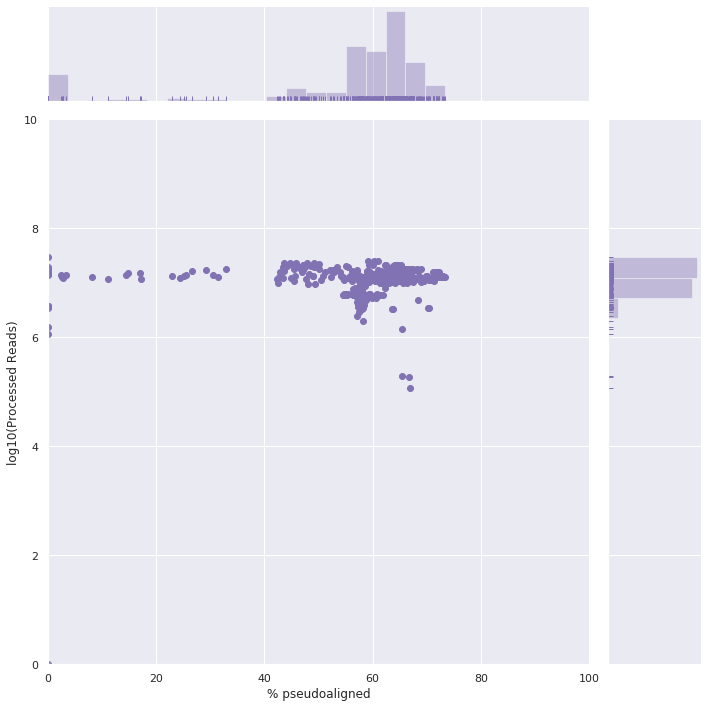

In [14]:
#@title Scatter plot of log10( number of processed reads ) against % of targets pseudoaligned in each experiment


sns.set(style="darkgrid")

qc_dfa = pd.DataFrame({'% pseudoaligned': p_pseudoaligned, 'log10(Processed Reads)': log10processed})
g = sns.jointplot('% pseudoaligned', 'log10(Processed Reads)', data = qc_dfa, kind="scatter",
                  xlim=(0, 100), ylim=(0, 10), color="m", height=10, marginal_kws=dict(bins=20, rug=True))

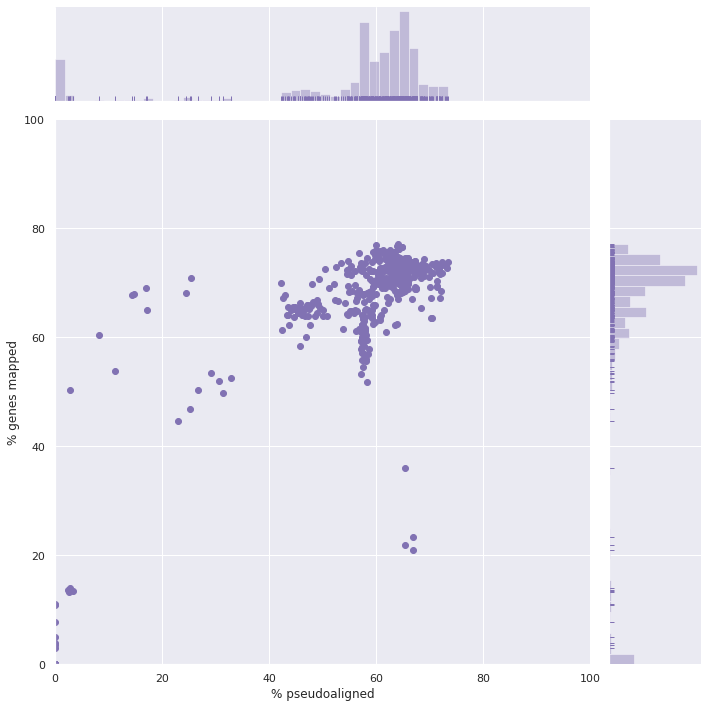

In [15]:
#@title Scatter plot of % of genes mapped against % of targets pseudoaligned in each experiment

sns.set(style="darkgrid")

qc_dfb = pd.DataFrame({'% pseudoaligned': p_pseudoaligned, '% genes mapped': p_genes_mapped})
g = sns.jointplot('% pseudoaligned', '% genes mapped', data = qc_dfb, kind="scatter",
                  xlim=(0, 100), ylim=(0, 100), color="m", height=10, marginal_kws=dict(bins=40, rug=True))

In [18]:
#@title Determine Quality Control Cutoff {display-mode: "form", run: "auto"}
#@markdown Assess the qc_file output. Then arbitarily decide on the treshold values. Only RunIDs with threshold above these will be used for analysis. 

p_pseudoaligned_threshold = 40  #@param {type: "slider", min: 0, max: 100}

#@markdown Enter the log<sub>10</sub> of reads processed instead of absolute number.
reads_processed_threshold = 6 #@param {type: "slider", min: 0, max: 10, step: 0.1}

p_genes_mapped_threshold = 60 #@param {type: "slider", min: 0, max: 100}

#title Collect RunIDs above threshold
accepted_RunIDs = []
ra = qc_df.loc[:,"Reads Pseudoaligned"]
rp = qc_df.loc[:,"Reads Processed"]
gm = qc_df.loc[:,"% genes mapped"]

for i in range(len(ra)):
  if ra[i] >= p_pseudoaligned_threshold and rp[i] >= reads_processed_threshold and gm[i] >= p_genes_mapped_threshold:
    accepted_RunIDs.append(qc_df.loc[i,"RunID"])

print("Number of accepted Run IDs:"+ str(len(accepted_RunIDs)) + "/" + str(len(ra)))

#to_recompile_tpm_values = False #@param {type:"boolean"}

Number of accepted Run IDs:442/523


###2.2 Data Extraction

####Compile TPM values

In [0]:
#Functions#############################################################
def compile_tpm(accepted_RunIDs, tpm_table_file_name):
  #Iterate through the list of selected RunIDs
  for RunID in accepted_RunIDs:
    RunID_file_path = execution_dir_path + RunID + "/"
    if os.path.exists(RunID_file_path) == False:
      print(RunID + ": RunID directory not found.")
    else:
      abun = pd.read_csv(RunID_file_path + "abundance.tsv", sep='\t', header=0, engine="python") #opens abundance.tsv as df
      if RunID == accepted_RunIDs[0]:
        master_tpm = abun[["target_id"]].copy()
      master_tpm.insert(1, RunID, abun["tpm"]) #adds tpm column to collection of tpm values
  master_tpm["target_id"] = master_tpm["target_id"].apply(lambda x: x.lower()) #convert gene IDs to lowercase to match mercator results
  master_tpm.to_csv(execution_dir_path + tpm_table_file_name, index=False, sep="\t")
  print("TPM table created.\n")

######################################################################

In [31]:
tpm_table_file_name = "compiled_tpm_table_" + abv + ".txt"
# dict_of_genes = compile_tpm(accepted_RunIDs, tpm_table_file_name)
compile_tpm(accepted_RunIDs, tpm_table_file_name)

TPM table created.



####Set cutoff

In [0]:
#@title PCC Cutoff & Neighbourhood size {display-mode: "form", run: "auto"}

cutoff = 0.70  #@param {type:"slider", min:0, max:1, step:0.01}
neighbourhood_size = 51 #@param {type: "slider", min:1, max:201, step:1}

#to_recompile_files = False #@param {type:"boolean"}

####Generate PCC between pairs of genes
Ouputs for each guide gene:
- Neighbourhood file
- Network file

In [0]:
#@title
#Functions#############################################################

def extract_mercator(mercator_file_path):
  #Stores gene description
  with open(mercator_file_path, 'r') as mercator_file:
    mercator_file.readline() #header
    mercator_lines = mercator_file.readlines()

  description_dict = {}

  for line in mercator_lines:
    line_list = line.strip().split('\t')
    geneID = line_list[2].strip('\'')
    bin_code = line_list[0].strip('\'')
    bin_name = line_list[1].strip('\'')
    gene_description = line_list[3].strip('\'')
    if geneID != '':
      description_dict[geneID] = [bin_code, bin_name, gene_description]

  return description_dict

######################################################################

def read_tpm_table(tpm_table_file_path):
  #Read TPM Table
  compiled_tpm_table = open(tpm_table_file_path, "r")
  #Read header and store RunIDs, use index of RunID to identify. 
  RunID_list = compiled_tpm_table.readline().strip().split()[1:]

  #Read each row for each gene
  #[genes, ...]
  #[[tpm of gene 1], [tpm of gene 2], ...]
  genes_tpm_rows = compiled_tpm_table.readlines() #list of rows
  genes_list = [line.strip().split('\t')[0] for line in genes_tpm_rows]
  tpm_list_of_lists = [line.strip().split('\t')[1:] for line in genes_tpm_rows]
  compiled_tpm_table.close()

  return RunID_list, genes_list, tpm_list_of_lists

# ######################################################################

# def verify_guide_genes(list_of_guide_genes, genes_list):
#   #Check if guide genes inserted in input section is a GeneID present in genes_list
#   for guide_gene in list_of_guide_genes:
#     if guide_gene not in genes_list:
#       print("The gene " + guide_gene + " is invalid.")
#       list_of_guide_genes.remove(guide_gene)
  
#   return list_of_guide_genes

######################################################################

def make_neighbourhood_file(GoI, neighbourhood_file_path, genes_list, tpm_list_of_list, description_dict):
  #1 Create neightbourhood file output for this guide gene
  neighbourhood_file = open(neighbourhood_file_path, 'w+')
  neighbourhood_file.write('Neighbourhood file for ' + GoI + '\n')
  neighbourhood_file.write('Gene ID\tPCC Value\tp-value\tMapman Bin Code\tMapman Bin Name\tDescription\n')

  GoI_index = genes_list.index(GoI)
  tpm_GoI = [float(tpm) for tpm in tpm_list_of_lists[GoI_index]]

  #Generate a list of list [[gene ID, PCC, p-value], [], ...]
  PCC_output = []

  #Pair GoI with every other gene in genes_list
  for i in range(len(genes_list)):
    tpm_gene2 = [float(tpm) for tpm in tpm_list_of_lists[i]]
    PCC_value, p_value = stats.pearsonr(tpm_GoI, tpm_gene2)
    if PCC_value > cutoff: #Only append pairs with PCC > cutoff
      PCC_output.append([genes_list[i], PCC_value, p_value])

  #Sort by PCC
  PCC_sorted = sorted(PCC_output, key = lambda x: x[1], reverse = True)
  PCC_top = PCC_sorted[:neighbourhood_size] #Write only the top PCC by neighbourhood size

  #Add gene description
  #description_dict = {geneID: [bin_code, gene_name, gene_description]}
  PCC_top_annotated = []
  for result in PCC_top:
    geneID = result[0]
    result.extend(description_dict[geneID]) #extend with [bin_code, bin name, genedesc]
    PCC_top_annotated.append(result) #[gene ID, PCC, p-value, bin_code, bin name, genedesc]

  #write to neighbourhood file
  for result in PCC_top_annotated: 
    result = [str(e) for e in result]
    to_write = '\t'.join(result) + '\n' 
    neighbourhood_file.write(to_write)

  neighbourhood_file.close()

  print(GoI + ": neighbourhood file created.")

######################################################################

def create_network(GoI, neighbourhood_file_path, network_file_path, genes_list, tpm_list_of_lists):
  #Read neightbourhood file output
  with open(neighbourhood_file_path, 'r') as neighbourhood_file:
    neighbourhood_file.readline() #Title
    neighbourhood_file.readline() #Headers
    neighbourhood_lines = neighbourhood_file.readlines()

  #Collect top genes including GoI itself
  network_genes = [line.strip().split('\t')[0] for line in neighbourhood_lines]

  #Create network file output
  network_file = open(network_file_path, 'w+')
  network_file.write('Network file for ' + GoI + '\n')
  network_file.write('Gene ID 1\tGene ID 2\tPCC Value\tp-value\n')

  #Iterate every gene
  for gene1 in network_genes:
    network_genes_index = network_genes.index(gene1) #for iterating through only genes in neighbourhood file
    genes_list_index1 = genes_list.index(gene1) #find index of gene in genes_list from container extracted by read_tpm_table function
    #Pair gene with every other gene below it in the list
    for i in range((network_genes_index + 1), len(network_genes)): #gene2 is iterated through all the genes below gene1 
      gene2 = network_genes[i]
      tpm_gene1 = [float(Exp) for Exp in tpm_list_of_lists[genes_list_index1]]
      genes_list_index2 = genes_list.index(gene2)
      tpm_gene2 = [float(Exp) for Exp in tpm_list_of_lists[genes_list_index2]]
      PCC_value, p_value = stats.pearsonr(tpm_gene1, tpm_gene2)

      if math.isnan(PCC_value):
        PCC_value, p_value = 0, 0

      if cutoff <= PCC_value <= 1.0:
        to_write = gene1 + '\t' + gene2 + '\t' + str(PCC_value) + '\t' + str(p_value) + '\n' 
        network_file.write(to_write)

  network_file.close()
  print(GoI + ": network file created.")

######################################################################

In [9]:
# Extract Mercator Description
description_dict = extract_mercator(merloc)

# Read TPM table 
tpm_table_file_path = execution_dir_path + tpm_table_file_name 
RunID_list, genes_list, tpm_list_of_lists = read_tpm_table(tpm_table_file_path) 

# # Get guide genes. Marek: just replace with function t hat checks if user gene exists
# list_of_guide_genes = verify_guide_genes(list_of_guide_genes, genes_list)

if goi in genes_list:
#for guide_gene in list_of_guide_genes:
  #1 Create neighbourhood file
  neighbourhood_file_path = execution_dir_path + 'Neighbourhood_' + goi.replace("|","_") + '.txt'
 # if (not os.path.exists(neighbourhood_file_path)) or to_recompile_files == True:
  make_neighbourhood_file(goi, neighbourhood_file_path, genes_list, tpm_list_of_lists, description_dict)
 # else:
 #   print(goi + ": neighbourhood file already present.")
  
  #2 Create network file
  network_file_path = execution_dir_path + 'Network_' + goi.replace("|","_") + '.txt'
  # if (not os.path.exists(network_file_path)) or to_recompile_files == True:
  create_network(goi, neighbourhood_file_path, network_file_path, genes_list, tpm_list_of_lists) #Requires neighbourhood file to be created first
  # else:
  #   print(goi + ": network file already present.")

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


lcl|nw_015787229.1_cds_xp_016497259.1_1: neighbourhood file created.
lcl|nw_015787229.1_cds_xp_016497259.1_1: network file created.


##3. Visualisation of Co-expression Networks

####Function to generate network html files

---



In [0]:
#Functions#############################################################

def extract_nodes_and_edges(network_file_path):
  '''Opens a network file and return a list of all the edges and nodes within the network'''
  with open(network_file_path, 'r') as network_file:
    network_file.readline() #title
    network_file.readline() #header
    entries = [lines.strip().split('\t') for lines in network_file.readlines()]

  list_of_edges = []
  for i in range(len(entries)):
    if float(entries[i][2]) >= 0.7:
      edge = (entries[i][0], entries[i][1])
      list_of_edges.append(edge)

  list_of_nodes = []
  for j in list_of_edges:
    if j[0] not in list_of_nodes:
      list_of_nodes.append(j[0])
    if j[1] not in list_of_nodes:
      list_of_nodes.append(j[1])
  
  return list_of_nodes, list_of_edges

######################################################################

  def style_one_node(GeneID, shape, color):
  '''Returns the string of html css style sheet to be added to the index html file'''
  node_styling='''\
              {
              selector: 'node[id="GENEID"]',
              style: {
                  shape: 'ENTER_SHAPE',
                  'background-color': 'ENTER_COLOR',
                  }
              },
'''
  node_styling = node_styling.replace('GENEID', GeneID)
  node_styling = node_styling.replace('ENTER_SHAPE', shape)
  node_styling = node_styling.replace('ENTER_COLOR', color)

  return node_styling

######################################################################

def read_neighbourhood_file(neighbourhood_file_path):
  with open(neighbourhood_file_path, "r") as neighbourhood_file:
    neighbourhood_file.readline() #title
    neighbourhood_file.readline() #header
    lines_list = [line.strip().split("\t") for line in neighbourhood_file.readlines()]

  # gene_info_dict = {GeneId : [bin_code, bin_fullname, description, ##arabiposis ortholog?##]}
  gene_info_dict = {}
  for line in lines_list:
    gene_info_dict[line[0]] = [line[3], line[4], line[5]]
  
  return gene_info_dict

######################################################################

def read_color_table(MapmanBin_color_table_path):
  '''Returns color_dict = {Bin number: [Bin name, shape, color]}'''
  with open(MapmanBin_color_table_path, "r") as color_table:
    color_table.readline() #header
    lines = [line.strip().split("\t") for line in color_table.readlines()]
  
  color_dict = {}
  for line in lines:
    color_dict[int(line[0])] = [line[1], line[2], line[3]]
  
  return color_dict

######################################################################

def generate_html_index(list_of_nodes, list_of_edges):
  '''Returns a string of a html with javascript code to render the network from list_of_nodes and list_of_edges'''
  front_html = '''\
  <!doctype html>
  <html>
    <head>
        <title>Network on Cytoscape</title>
        <script src='https://cdnjs.cloudflare.com/ajax/libs/cytoscape/3.9.4/cytoscape.min.js'></script>
    </head>

    <style>
        #cy {
            width: 1000px;
            height: 950px;
            }
    </style>

    <body style="background-color:rgb(194, 229, 243);">
      <div><p><a id="pngimage" href="#" download="NetworkImage.png">Click to Download as Image</a></p></div>
      <div><p><a id="cyjson" href="#" download="NetworkImage.json">Click to Download as JSON</a></p></div>
      <div id="cy"></div>
      <script>
        var cy = cytoscape({
          container: document.getElementById('cy'),
  '''


  mid_html = '''\
          elements: [
              nodes: [\n'''

  #Read neighbourhood files
  neighbourhood_file_path = execution_dir_path + 'Neighbourhood_' + goi.replace("|","_") + '.txt'
  gene_info_dict = read_neighbourhood_file(neighbourhood_file_path) #Need to include arabidopsis orthologs too! (run diamond?)

  #Read Mapman Bin to Color table
  MapmanBin_color_table_path = "/content/MapmanBin_colors.txt"
  color_dict = read_color_table(MapmanBin_color_table_path)

  all_node_styling = ""
  #Style every node from list_of_nodes[1:] based on bin codes
  for node in list_of_nodes[1:]:
    #get bin code
    bin_code = int(gene_info_dict[node][0].split(".")[0])
    shape, color = color_dict[bin_code][1], color_dict[bin_code][2]
    node_styling = style_one_node(node, shape, color)
    all_node_styling += node_styling

  #get nodes
  # { data: { id: 'a', node_type: 'q/t', color: 'x', shape: 'z' } },
  for j in list_of_nodes:
    bin_code = int(gene_info_dict[node][0].split(".")[0])
    shape, color = color_dict[bin_code][1], color_dict[bin_code][2]
    ntype = "linked"
    if j == list_of_nodes[0]:
      ntype = "query"
    new_node = "\t"*5 + "{\n" + "\t"*6 + "data: {\n" +\
      "\t"*6 + "id: \'" + j + "\',\n" +\
      "\t"*6 + "node_type: \'" + ntype + "\',\n" +\
      "\t"*6 + "color: \'" + color + "\',\n" +\
      "\t"*6 + "shape: \'" + shape + "\'\n" + "\t"*6 + "}\n" + "\t"*5 + "}"
    if j != len(list_of_nodes)-1:
      new_node += ",\n"
    else:
      new_node += "\n\t\t\t\t],\n"
    mid_html += new_node

  #get edges
  for i in range(len(list_of_edges)):
    ID = list_of_edges[i][0] + " | " + list_of_edges[i][1]
    source = list_of_edges[i][0]
    target = list_of_edges[i][1]
    new_edge = "\t"*5 + "{\n" + "\t"*6 + "data: {\n" +\
      "\t"*6 + "id: \'" + ID + "\',\n" +\
      "\t"*6 + "source: \'" + source + "\',\n" +\
      "\t"*6 + "target: \'" + target + "\'\n" + "\t"*6 + "}\n" + "\t"*5 + "}"
    if i != (len(list_of_edges)-1):
      new_edge += ",\n"
    else:
      new_edge = new_edge + "\n\t\t\t\t],\n"
    mid_html += new_edge

  back_html = '''\
            style: [
              { 
              selector: 'node',
              style: {
                  shape: 'data(shape)',
                  'height': '3px',
                  'width': '3px',
                  'background-color': 'white',
                  label: 'data(id)',
                  'border-style':'solid',
                  'border-color':'black',
                  'border-width':'0.1px',
                  'font-size': 1.2,
                  'text-margin-y':'-0.4px',
                  'text-outline-color':'white',
                  'text-outline-width':'0.15px',
                  'text-outline-opacity':0.8
                  }
              },
              {
                selector:'node[node_type="query"]',
                style: {
                  'color': 'gold',
                  'shape': 'star',
                  'text-outline-width': '0.15px',
                  'text-outline-colour': 'white'
                }
              },
              {
              selector: 'edge',
              style: {
                  'width': '0.1px',
                  'line-style':'solid',
                  'line-fill':'solid',
                  'background-color': '#F5F5F5',
                  'opacity':0.4
                  }
              },
              {
              selector:'core',
              style: {
                  'outside-texture-bg-color':'white',
                  'outside-texture-bg-opacity':1
                  }
              },
MORE_STYLES
              ],
            layout: {
              name: 'cose',
              animateThreshold: 1,
              nodeOverlap: 100,
              gravity: 400,
              componentSpacing: 100,
              edgeElasticity: 100,
              minTemp: 1,
              initialTemp: 1000,
              stop: function() {
                  //generate PNG image to display from "id = pngimage"
                  var png64 = cy.png({bg:'white'});
                  document.getElementById('pngimage').setAttribute('href', png64);
                  //generate JSON to download for id = cyjson
                  var eles = cy.elements(),
                      jsonc = '';

                  eles.each(function (i, ele) {
                      if (ele.isNode()) {
                          ele.data('current_color', ele.renderedStyle('background-color'));
                          ele.data('current_shape', ele.renderedStyle('shape'));
                      } else if (ele.isEdge()) {
                          ele.data('current_color', ele.renderedStyle('line-color'));
                          ele.data('current_width', ele.renderedStyle('width'));
                      }
                  });

                  jsonc = JSON.stringify(cy.json(), null, "\t");
                  document.getElementById('cyjson').setAttribute('href', 'data:text/plain;charset=utf-8,' + encodeURIComponent(jsonc));
                  }
              }
          });

      </script>
    </body>
  </html>
  '''

  index_html = front_html + mid_html + back_html
  return index_html

######################################################################

def save_index_file(index_html, guide_gene):
  '''Writes the html/js string into a html file and return the path to the new html file'''
  network_html_path = execution_dir_path + "Network_index_" + guide_gene + '.html'
  with open(network_html_path, 'w+') as index_file:
    index_file.write(index_html)
  return network_html_path

######################################################################



Calling the functions to create the network html files

In [0]:
# execution_dir_path = '/content/gdrive/My Drive/Elaeis_guineensis/2020-01-08_03/' #delete after
#network_files = [file for file in os.listdir(execution_dir_path) if ('Network' in file and 'html' not in file)]
#neighbourhood_files = [file for file in os.listdir(execution_dir_path) if ('Neighbourhood' in file and 'html' not in file)]

#list_of_network_html_path = []
#for guide_gene in list_of_guide_genes:
#Read network file for nodes and edges
list_of_nodes, list_of_edges = extract_nodes_and_edges(execution_dir_path + "Network_" + goi.replace("|","_") + ".txt")
index_html = generate_html_index(list_of_nodes, list_of_edges) #string

# #Read neighbourhood files
# neighbourhood_file_path = execution_dir_path + 'Neighbourhood_' + goi.replace("|","_") + '.txt'
# gene_info_dict = read_neighbourhood_file(neighbourhood_file_path) #Need to include arabidopsis orthologs too! (run diamond?)

# #Read Mapman Bin to Color table
# MapmanBin_color_table_path = "/content/MapmanBin_colors.txt"
# color_dict = read_color_table(MapmanBin_color_table_path)

# all_node_styling = ""
# #Style every node from list_of_nodes[1:] based on bin codes
# for node in list_of_nodes[1:]:
#   #get bin code
#   bin_code = int(gene_info_dict[node][0].split(".")[0])
#   shape, color = color_dict[bin_code][1], color_dict[bin_code][2]
#   node_styling = style_one_node(node, shape, color)
#   all_node_styling += node_styling

index_html = index_html.replace('NetworkImage', goi.replace("|","_")) #Specify Name of png file to be downloaded based on guide gene

#Style the guide gene (First in neighbourhood file) as gold star
guide_gene_style = style_one_node(list_of_nodes[0], "star", "Gold")
all_node_styling += guide_gene_style

#replace 
index_html = index_html.replace('MORE_STYLES', all_node_styling)

# Save string into final html file
network_html_path = save_index_file(index_html, goi.replace("|","_"))
#list_of_network_html_path.append(network_html_path)

####Rendering the networks

In [12]:
#@title Legend for nodes based on Mapman Bins:

#color_dict = {Bin number: [Bin name, shape, color]}
color_dict = read_color_table(MapmanBin_color_table_path)

nodes_elements = ""
nodes_style = ""

for key in color_dict:
  bin_name, shape, color = color_dict[key][0], color_dict[key][1], color_dict[key][2]
  #Add node to elements
  new_node = "\t"*5 + "{data: {id:\'" + bin_name + "\'}},\n"
  nodes_elements += new_node
  #Add shape and color to node
  nodes_style += style_one_node(bin_name, shape, color)

legend_html_head = '''\
  <!doctype html>
  <html>
    <head>
        <title>Network on Cytoscape</title>
        <script src='https://cdnjs.cloudflare.com/ajax/libs/cytoscape/3.9.4/cytoscape.min.js'></script>
    </head>

    <style>
        #cy {
            width: 900px;
            height: 950px;
            }
    </style>
    
    <body>
      <div id="cy"></div>
      <script>
        var cy = cytoscape({
          container: document.getElementById('cy'),
            elements: [
				          // nodes
'''

legend_html_mid ='''
			      ],
            style: [
              {
              // Set the default node styling first
              selector: 'node',
              style: {
                  shape: 'circle',
                  'height': '20px',
                  'width': '20px',
                  'background-color': 'white',
                  'background-opacity':1,
                  label: 'data(id)',
                  'border-style':'solid',
                  'border-color':'black',
                  'border-width':'0.1px',
                  'font-size': 12,
                  'text-margin-y':'-20px',
                  'text-outline-color':'white',
                  'text-outline-width':'0.15px',
                  'text-outline-opacity':0.8
                  }
              },
              // Modify the node styling individually
'''

legend_html_tail ='''
              // Edge styling
              {
              selector: 'edge',
              style: {
                  'width': '0.1px',
                  'line-style':'solid',
                  'line-fill':'solid',
                  'background-color': '#F5F5F5',
                  'opacity':0.4
                  }
              },
              {
              selector:'core',
              style: {
                  'outside-texture-bg-color':'white',
                  'outside-texture-bg-opacity':1
                  }
              }
              ],
            layout: {
              name: 'grid',
              }
          });
          cy.zoomingEnabled(false);
      </script>
    </body>
  </html>
'''

legend_html = legend_html_head + nodes_elements.rstrip(",\n") + legend_html_mid + nodes_style + legend_html_tail
display(HTML(legend_html))

In [20]:
#@title Show Network
#network_html_path = list_of_network_html_path[0]
IPython.display.HTML(filename = network_html_path)

In [0]:
#@title
# #@title Gene Query - First network { run: "auto" }

# GeneID = "EGU2621G0126.01" #@param {type:"string"}

# k = 0 #Guide Gene index
# neighbourhood_file_path = execution_dir_path + 'Neighbourhood_' + list_of_guide_genes[k] + '.txt'
# gene_info_dict = read_neighbourhood_file(neighbourhood_file_path) 
# # gene_info_dict = {GeneId : [bin_code, bin_fullname, description, ##arabiposis ortholog?##]}

# if GeneID in gene_info_dict.keys():
#   info = gene_info_dict[GeneID]
#   print("GeneID: " + GeneID)
#   print("Mapman Bin Code: " + info[0])
#   print("Mapman Bin Name: " + info[1])
#   print("Dsecription: " + info[2])

# else:
#   print("Invalid GeneID")

GeneID: EGU2621G0126.01
Mapman Bin Code: 15.5.7.3
Mapman Bin Name: RNA biosynthesis.transcriptional regulation.AP2/ERF  transcription factor superfamily.transcription factor (AP2)
Dsecription: transcription factor (AP2) (original description: | EGU2621G0126)
GeneID: EGU2621G0126.01
Mapman Bin Code: 15.5.7.3
Mapman Bin Name: RNA biosynthesis.transcriptional regulation.AP2/ERF  transcription factor superfamily.transcription factor (AP2)
Dsecription: transcription factor (AP2) (original description: | EGU2621G0126)


In [59]:
#@title Details of Genes in First Network
#neighbourhood_file_path = neighbourhood_files[0]
df = pd.read_table(neighbourhood_file_path, sep="\t", header=1)
pd.set_option('display.max_colwidth', -1)
df[["Gene ID", "PCC Value", "Mapman Bin Code", "Mapman Bin Name", "Description"]]

,Gene ID,PCC Value,Mapman Bin Code,Mapman Bin Name,Description
0,lcl|nw_015787229.1_cds_xp_016497259.1_1,1.000000,22.3.4.1,Vesicle trafficking.Coat protein I (COPI) coatomer machinery.ARF-GTPase-activating (ARF-GAP) activities.class I ARF-GAP protein,"class I ARF-GAP ARF-GTPase-activating protein (original description: [gene=LOC107813361] [db_xref=GeneID:107813361] [protein=ADP-ribosylation factor GTPase-activating protein AGD2-like] [protein_id=XP_016497259.1] [location=join(21..168,253..392,556..610,2767..2886,2974..3030,4652..4941,5490..5573,5649..5921,8423..8544,8893..8980,10502..10947,12214..12328)] [gbkey=CDS])"
1,lcl|nw_015899831.1_cds_xp_016449857.1_44363,0.823564,19.4.2.1.6,Protein homeostasis.proteolysis.serine-type peptidase activities.S8-class protease (subtilisin) families.protease (SBT6.1),"protease (SBT6.1) (original description: [gene=LOC107774733] [db_xref=GeneID:107774733] [protein=subtilisin-like protease SBT6.1] [partial=5'] [protein_id=XP_016449857.1] [location=complement(join(32538..32620,32710..32770,33033..33524,34109..35177,35258..35521,36014..36198,37174..37300,38519..>38613))] [gbkey=CDS])"
2,lcl|nw_015887819.1_cds_xp_016442297.1_37572,0.803507,35.1,not assigned.annotated,"(original description: [gene=LOC107767726] [db_xref=GeneID:107767726] [protein=protein transport protein SEC24-like] [protein_id=XP_016442297.1] [location=complement(join(9490..9701,9799..10013,11283..11560,15280..15403,16469..16567,17077..17192,17278..17359,18512..18666,18744..18889,19132..19318,19440..19612,19703..19756,20650..20709,20821..21148))] [gbkey=CDS]) & Protein transport protein Sec24-like At3g07100 OS=Arabidopsis thaliana (sp|q9sfu0|sc24a_arath : 107.0)"
3,lcl|nw_015826145.1_cds_xp_016502566.1_16195,0.791552,35.1,not assigned.annotated,"(original description: [gene=LOC107820741] [db_xref=GeneID:107820741] [protein=phosphatidylinositol 4-kinase alpha 1] [protein_id=XP_016502566.1] [location=complement(join(42479..42680,42805..42977,43534..43578,43714..43791,44200..44466,47362..47512,47604..47737,47908..48088,52376..52590,53430..53789,53912..54406,54874..55056,55156..55314,56373..56590,56744..56912,60700..61006,61084..61211,61301..61459,61601..61771,67104..67259,67354..67695,67980..68819))] [gbkey=CDS]) & Phosphatidylinositol 4-kinase alpha 1 OS=Arabidopsis thaliana (sp|q9sxa1|p4ka1_arath : 2081.0)"
4,lcl|nw_015914710.1_cds_xp_016464667.1_57687,0.789817,19.3.3.3,Protein homeostasis.autophagy.ATG8/ATG12 conjugation system.ATG8/12-activating E1 protein (ATG7),"ATG7 autophagosome ATG8/12-activating E1 protein (original description: [gene=LOC107787591] [db_xref=GeneID:107787591] [protein=ubiquitin-like modifier-activating enzyme atg7] [protein_id=XP_016464667.1] [location=join(3470..3605,4205..4422,4675..4866,4948..5002,5106..5200,5365..5554,5652..5757,5832..5976,6067..6225,6326..6514,6641..6841,6926..7041,7128..7287,7476..7655)] [gbkey=CDS])"
5,lcl|nw_015938284.1_cds_xp_016483241.1_74377,0.789364,22.8.4.1.1,Vesicle trafficking.regulation of membrane tethering and fusion.RAB-GTPase membrane association.RAB-GTPase geranylgeranyltransferase (RGT) complex.subunit alpha,"subunit alpha of RAB-GTPase geranylgeranyltransferase (RGT) complex (original description: [gene=LOC107803956] [db_xref=GeneID:107803956] [protein=uncharacterized protein LOC107803956] [protein_id=XP_016483241.1] [location=join(28162..28277,28377..28545,29232..29392,29476..29580,30851..31651,31745..31934,32596..32779,35170..35564)] [gbkey=CDS])"
6,lcl|nw_015938284.1_cds_xp_016483242.1_74378,0.789364,22.8.4.1.1,Vesicle trafficking.regulation of membrane tethering and fusion.RAB-GTPase membrane association.RAB-GTPase geranylgeranyltransferase (RGT) complex.subunit alpha,"subunit alpha of RAB-GTPase geranylgeranyltransferase (RGT) complex (original description: [gene=LOC107803956] [db_xref=GeneID:107803956] [protein=uncharacterized protein LOC107803956] [protein_id=XP_016483242.1] [location=join(28162..28277,28377..28545,29232..29392,29476..29580,30851..31651,31745

\- End of Script -